In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

from models.regression import BayesianRegressor
from utils.experiments import experiment


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Creating Training Data

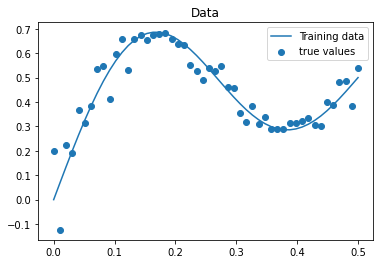

In [4]:
# toy dataset we can start with
train_samples = 100
x_train, y_train = experiment(xmin = 0.0, xmax = 0.5, samples = 50, std = 0.02)
_, y_train_true = experiment(xmin = 0.0, xmax = 0.5, samples = 50, std = 0)

plt.plot(x_train.numpy(), y_train_true.detach().numpy(), label='Training data')
plt.scatter(x_train, y_train, label='true values')
plt.title('Data')
plt.legend()
plt.show()

Defining model and training

In [6]:
model = BayesianRegressor(hidden_dim=128, ll_var=0.05, mixture_prior=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
elbo_samples = 6
epochs = 2000

x_train = x_train.to(device)
y_train = y_train.to(device)

for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = model.energy_loss(x_train, y_train, elbo_samples)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch: {}/{}'.format(epoch + 1, epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/2000
Loss: 11496.5830078125
epoch: 101/2000
Loss: 2847.13671875
epoch: 201/2000
Loss: 2484.04833984375
epoch: 301/2000
Loss: 2264.2109375
epoch: 401/2000
Loss: 1974.531005859375
epoch: 501/2000
Loss: 1872.863037109375
epoch: 601/2000
Loss: 1744.7391357421875
epoch: 701/2000
Loss: 1696.8135986328125
epoch: 801/2000
Loss: 1661.3828125
epoch: 901/2000
Loss: 1632.222900390625
epoch: 1001/2000
Loss: 1621.892333984375
epoch: 1101/2000
Loss: 1541.5540771484375
epoch: 1201/2000
Loss: 1601.9168701171875
epoch: 1301/2000
Loss: 1494.186279296875
epoch: 1401/2000
Loss: 1495.0556640625
epoch: 1501/2000
Loss: 1474.016357421875
epoch: 1601/2000
Loss: 1420.0428466796875
epoch: 1701/2000
Loss: 1389.71337890625
epoch: 1801/2000
Loss: 1412.222900390625
epoch: 1901/2000
Loss: 1348.6712646484375
Finished Training


Prediction

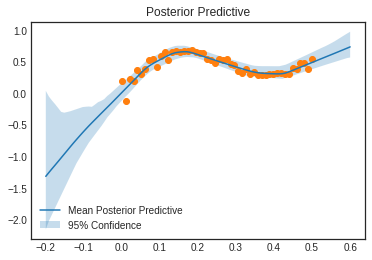

In [8]:
# samples is the number of "predictions" we make for 1 x-value.
test_samples = 100
exp_samples = 100
x_test, y_test = experiment(xmin = -0.2, xmax = 0.6, samples = test_samples, std = 0.02)
y_samp = np.zeros((exp_samples, test_samples))
# Testing experiment
x_test = x_test.to(device)
for s in range(exp_samples):
    y_hat = model.forward(x_test).cpu().detach().numpy()
    y_samp[s, :] = y_hat.reshape(-1)
plt.plot(x_test.cpu().detach().numpy(), np.mean(y_samp, axis=0), label='Mean Posterior Predictive')
plt.fill_between(x_test.cpu().detach().numpy().reshape(-1), np.percentile(y_samp, 2.5, axis=0),
                 np.percentile(y_samp, 97.5, axis=0),
                 alpha=0.25, label='95% Confidence')
plt.legend()
plt.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())
plt.title('Posterior Predictive')
plt.show()


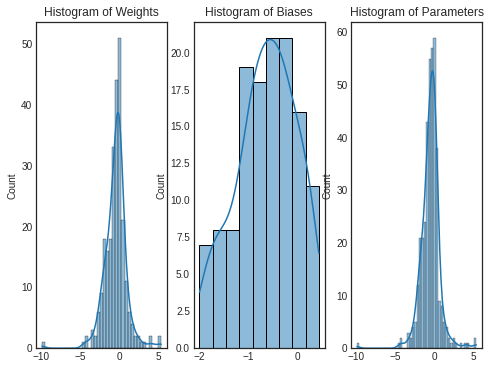

In [7]:
from utils.vis import weights_histogram

_, _ = weights_histogram(model)